### Figure 5 | Vaccination elicits coordinated pathway-level immune and metabolic responses in sarcoidosis
Pathway enrichment analyses summarize coordinated immune, metabolic, and stress-related transcriptional responses following vaccination.

In [2]:
## ============================================
## dream DiD contrasts for COVID Vax SARC vs HC
## Contrasts:
##   - Dose1: V1D7 − V1D0, ΔSX − ΔHC
##   - Dose2: V2D7 − V2D0, ΔSX − ΔHC
##   - Dose12 (cumulative): V2D7 − V1D0, ΔSX − ΔHC
## Outputs per contrast:
##   - gene-level CSV + fit RDS
##   - Hallmark / C7 VAX / Reactome FGSEA CSV + RDS
## ============================================

suppressPackageStartupMessages({
  library(SummarizedExperiment)
  library(edgeR)
  library(limma)
  library(variancePartition)   # dream
  library(BiocParallel)
  library(dplyr)
  library(readr)
  library(stringr)
  library(forcats)
  library(ggplot2)
  library(msigdbr)
  library(fgsea)
  library(AnnotationDbi)
  library(org.Hs.eg.db)
})
# Parallel setup
if (.Platform$OS.type == "windows") {
  BiocParallel::register(
    BiocParallel::SnowParam(workers = max(1, parallel::detectCores() - 1))
  )
} else {
  BiocParallel::register(
    BiocParallel::MulticoreParam(workers = max(1, parallel::detectCores() - 1))
  )
}
set.seed(42)

SCRIPT_REL_PATH <- NULL

if (is.null(SCRIPT_REL_PATH)) {
  # Interactive / notebook fallback: do not error, but warn if here() looks wrong
  if (!file.exists(here::here("README.md")) && !dir.exists(here::here(".git"))) {
    warning(
      "Repo root not detected via here(). ",
      "If paths are wrong, set your working directory to the repo root OR set SCRIPT_REL_PATH."
    )
  }
} else {
  here::i_am(SCRIPT_REL_PATH)
}

# ----------------------------
# Inputs
# ----------------------------
DATA_ROOT <- Sys.getenv("SARC_DATA_ROOT")

DATA_DIR <- here::here("data", "derived")
dir.create(DATA_DIR, recursive = TRUE, showWarnings = FALSE)

TAB_DIR <- here::here("tables", "main")
dir.create(TAB_DIR, recursive = TRUE, showWarnings = FALSE)

FIG_DIR <- here::here("figures", "main")
dir.create(FIG_DIR, recursive = TRUE, showWarnings = FALSE)

if (DATA_ROOT == "") {
  # sensible default for your setup; change if needed
  DATA_ROOT <- "/mnt/z"
  Sys.setenv(SARC_DATA_ROOT = DATA_ROOT)
  message("SARC_DATA_ROOT was not set; using: ", DATA_ROOT)
}

# NOTE USES THE PAIRED ALL TIMEPOINTS SE FOR CONSISTENCY
if (!dir.exists(DATA_ROOT)) stop(glue("DATA_ROOT not found: {DATA_ROOT}"), call. = FALSE)
SE_RDS <- file.path(DATA_ROOT, "se_paired_all_timepoints.rds")
if (!file.exists(SE_RDS)) stop(glue("Missing input file: {SE_RDS}"), call. = FALSE)
se_all_full <- readRDS(SE_RDS)

cd <- as.data.frame(colData(se_all_full))

stopifnot(exists("se_all_full"), is(se_all_full, "SummarizedExperiment"))

cd_all <- as.data.frame(colData(se_all_full))

visit_col <- intersect(c("time_point","m_time_point","visit","m_timepoint"), names(cd_all))[1]
group_col <- intersect(c("m_group","group","disease","m_disease_status"), names(cd_all))[1]
id_col    <- intersect(c("m_subj2","participant","subject_id","subject","subj2"), names(cd_all))[1]

stopifnot(length(visit_col) == 1,
          length(group_col) == 1,
          length(id_col) == 1)

message("Using visit_col = ", visit_col,
        ", group_col = ", group_col,
        ", id_col = ", id_col)

## --------------------------------------------
## 1) Helpers
## --------------------------------------------

ens2sym <- function(ids) {
  ids2 <- sub("\\.\\d+$", "", as.character(ids))
  sym <- suppressMessages(
    AnnotationDbi::mapIds(
      org.Hs.eg.db,
      keys      = unique(ids2),
      keytype   = "ENSEMBL",
      column    = "SYMBOL",
      multiVals = "first"
    )[ids2]
  )
  sym <- unname(sym)
  ifelse(is.na(sym) | sym == "", ids2, sym)
}

# Clean Hallmark labels for plotting / tables
clean_hallmark_labels <- function(x) {
  x |>
    stringr::str_replace("^HALLMARK_", "") |>
    stringr::str_replace_all("_", " ") |>
    stringr::str_to_title() |>
    stringr::str_replace_all("\\bTnfa\\b", "TNF-α") |>
    stringr::str_replace_all("\\bNf[- ]?Kb\\b", "NF-κB") |>
    stringr::str_replace_all("\\bBeta Catenin\\b", "β-Catenin") |>
    stringr::str_replace_all("\\bG2 M\\b", "G2/M") |>
    stringr::str_replace_all("\\bE2 F\\b", "E2F") |>
    stringr::str_replace_all("\\bIl6\\b", "IL6") |>
    stringr::str_replace_all("\\bJak\\b", "JAK") |>
    stringr::str_replace_all("\\bStat3\\b", "STAT3") |>
    stringr::str_replace_all("\\bPi3K\\b", "PI3K") |>
    stringr::str_replace_all("\\bAkt\\b", "AKT") |>
    stringr::str_replace_all("\\bMtor\\b", "mTOR") |>
    (\(s) stringr::str_replace_all(s, "\\bUv Response (Up|Dn)\\b", "UV response (\\1)"))()
}

# Generic cleaner for non-Hallmark
clean_pathway_label_generic <- function(x) {
  x |>
    stringr::str_replace("^HALLMARK_", "") |>
    stringr::str_replace_all("_", " ") |>
    stringr::str_to_title()
}

# MSigDB helpers
get_msigdb_pathways <- function(category, subcategory = NULL,
                                species = "Homo sapiens") {
  df <- msigdbr::msigdbr(
    species    = species,
    category   = category,
    subcategory = subcategory
  ) |>
    dplyr::select(gs_name, gene_symbol)
  split(df$gene_symbol, df$gs_name)
}

run_fgsea_collection <- function(pathways,
                                 ranks,
                                 label_cleaner = clean_pathway_label_generic,
                                 minSize = 15,
                                 maxSize = 500) {
  set.seed(1)
  fgsea::fgsea(
    pathways = pathways,
    stats    = ranks,
    minSize  = minSize,
    maxSize  = maxSize
  ) |>
    dplyr::arrange(padj) |>
    dplyr::mutate(
      direction = dplyr::if_else(NES > 0, "Enriched in ΔSX", "Enriched in ΔHC"),
      path_clean = label_cleaner(pathway),
      signif = dplyr::case_when(
        padj < 0.001 ~ "***",
        padj < 0.01  ~ "**",
        padj < 0.05  ~ "*",
        TRUE         ~ ""
      )
    )
}

## --------------------------------------------
## 2) Core function to run one DiD contrast
## --------------------------------------------

run_did_contrast <- function(visit_pair, contrast_tag, out_dir) {
  # visit_pair: c("V1D0","V1D7"), c("V2D0","V2D7"), or c("V1D0","V2D7")
  # contrast_tag: "Dose1", "Dose2", "Dose12"
  
  cd_all <- as.data.frame(colData(se_all_full))
  cd_all$visit_raw <- toupper(trimws(as.character(cd_all[[visit_col]])))
  cd_all$g_raw     <- toupper(trimws(as.character(cd_all[[group_col]])))
  cd_all$subject   <- factor(trimws(as.character(cd_all[[id_col]])))
  
  # Subset to chosen visits and HC/SX
  keep    <- cd_all$visit_raw %in% visit_pair & cd_all$g_raw %in% c("HC","SX")
  se_sub  <- se_all_full[, keep, drop = FALSE]
  md      <- as.data.frame(colData(se_sub))
  
  # Clean factors
  md$visit   <- factor(toupper(trimws(as.character(md[[visit_col]]))),
                       levels = visit_pair)
  md$g       <- factor(toupper(trimws(as.character(md[[group_col]]))),
                       levels = c("HC","SX"))
  md$subject <- factor(trimws(as.character(md[[id_col]])))
  
  # Paired subjects must have both visits in visit_pair
  paired_subj <- md %>%
    dplyr::group_by(subject) %>%
    dplyr::summarise(
      has_a = any(visit == visit_pair[1]),
      has_b = any(visit == visit_pair[2]),
      .groups = "drop"
    ) %>%
    dplyr::filter(has_a & has_b) %>%
    dplyr::pull(subject)
  
  keeplog <- md$subject %in% paired_subj
  se_sub  <- se_sub[, keeplog, drop = FALSE]
  md      <- as.data.frame(colData(se_sub))
  md$visit   <- factor(toupper(trimws(as.character(md[[visit_col]]))),
                       levels = visit_pair)
  md$g       <- factor(toupper(trimws(as.character(md[[group_col]]))),
                       levels = c("HC","SX"))
  md$subject <- factor(trimws(as.character(md[[id_col]])))
  
  message(sprintf("[%s] PAIRS — subjects: %d  (HC: %d, SX: %d)",
                  contrast_tag,
                  length(unique(md$subject)),
                  length(unique(md$subject[md$g=="HC"])),
                  length(unique(md$subject[md$g=="SX"]))))
  print(with(md, table(g, visit)))
  
  # Counts → edgeR → voom
  cts <- assay(se_sub, "counts"); if (!is.matrix(cts)) cts <- as.matrix(cts)
  storage.mode(cts) <- "integer"; cts[!is.finite(cts)] <- 0L
  stopifnot(identical(colnames(cts), rownames(md)))
  
  dge <- DGEList(cts)
  keep_genes <- rowSums(cpm(dge) >= 1) >= max(2, ceiling(0.2 * ncol(dge)))
  dge <- dge[keep_genes, , keep.lib.sizes = FALSE]
  dge <- calcNormFactors(dge)
  
  X <- model.matrix(~ g * visit, data = md)
  v <- voom(dge, design = X, plot = FALSE)
  
  # dream model
  form <- ~ g * visit + (1 | subject)
  
  fit <- dream(v, form, md)
  fit <- eBayes(fit)
  coef_names <- colnames(fit$coefficients)
  if (is.null(coef_names)) coef_names <- colnames(limma::coef(fit))

  coef_pattern <- paste0("gSX:visit", visit_pair[2], "|visit", visit_pair[2], ":gSX")
  coef_name <- grep(coef_pattern, coef_names, value = TRUE)

  if (length(coef_name) != 1) {
    message("Available coefficients:\n", paste(coef_names, collapse = "\n"))
    stop("Could not uniquely identify interaction coefficient for ", contrast_tag)
  }
  message("Using coefficient: ", coef_name)  
  
  # Gene-level table
  tt <- limma::topTable(fit, coef = coef_name, number = Inf, sort.by = "P")
  tt$symbol  <- ens2sym(rownames(tt))
  tt$gene_id <- rownames(tt)
  tt <- tt |>
    dplyr::select(symbol, gene_id, logFC, AveExpr, t, P.Value, adj.P.Val, B)
  
  readr::write_csv(
    tt,
    file.path(TAB_DIR, paste0(contrast_tag, "_Delta_SXminusHC_gene_results_dream.csv"))
  )
  saveRDS(
    list(fit = fit, md = md, coef_name = coef_name, form = form, visit_pair = visit_pair),
    file.path(DATA_DIR, paste0(contrast_tag, "_dream_fit.rds"))
  )
  
  # Ranks for FGSEA
  ranks <- tt$t
  names(ranks) <- tt$symbol
  ranks <- ranks[is.finite(ranks) & !is.na(names(ranks))]
  ranks <- tapply(ranks, names(ranks), function(x) x[which.max(abs(x))]) |> unlist()
  ranks <- sort(ranks, decreasing = TRUE)
  
  # FGSEA collections
  # Hallmark
  msig_H <- get_msigdb_pathways("H")
  fg_H <- run_fgsea_collection(
    pathways      = msig_H,
    ranks         = ranks,
    label_cleaner = clean_hallmark_labels
  )
  readr::write_csv(
    fg_H,
    file.path(TAB_DIR, paste0(contrast_tag, "_GSEA_Hallmark_dream.csv"))
  )
  saveRDS(
    fg_H,
    file.path(DATA_DIR, paste0(contrast_tag, "_GSEA_Hallmark_dream.rds"))
  )
  
  # C7 VAX
  msig_C7_VAX <- get_msigdb_pathways("C7", "VAX")
  fg_C7_VAX <- run_fgsea_collection(
    pathways      = msig_C7_VAX,
    ranks         = ranks,
    label_cleaner = clean_pathway_label_generic
  )
  readr::write_csv(
    fg_C7_VAX,
    file.path(TAB_DIR, paste0(contrast_tag, "_GSEA_C7_VAX_dream.csv"))
  )
  saveRDS(
    fg_C7_VAX,
    file.path(DATA_DIR, paste0(contrast_tag, "_GSEA_C7_VAX_dream.rds"))
  )
  
  # C2 Reactome
  msig_C2_REACTOME <- get_msigdb_pathways("C2", "CP:REACTOME")
  fg_C2_REACTOME <- run_fgsea_collection(
    pathways      = msig_C2_REACTOME,
    ranks         = ranks,
    label_cleaner = clean_pathway_label_generic
  )
  readr::write_csv(
    fg_C2_REACTOME,
    file.path(TAB_DIR, paste0(contrast_tag, "_GSEA_C2_CP_REACTOME_dream.csv"))
  )
  saveRDS(
    fg_C2_REACTOME,
    file.path(DATA_DIR, paste0(contrast_tag, "_GSEA_C2_CP_REACTOME_dream.rds"))
  )
  
  # Repro crumbs
  writeLines(capture.output(sessionInfo()),
             file.path(TAB_DIR, paste0(contrast_tag, "_sessionInfo.txt")))
  writeLines(paste("dream formula:", deparse(form)),
             file.path(TAB_DIR, paste0(contrast_tag, "_model.txt")))
  writeLines(paste("Interaction coefficient:", coef_name),
             file.path(TAB_DIR, paste0(contrast_tag, "_coef_name.txt")))
  
  message("[", contrast_tag, "] complete. Outputs in: ", TAB_DIR)
  
  invisible(list(fg_H = fg_H, fg_C7_VAX = fg_C7_VAX, fg_C2_REACTOME = fg_C2_REACTOME))
}

## --------------------------------------------
## 3) Run all three contrasts
## --------------------------------------------

# Dose 1: V1D0 vs V1D7
res_dose1 <- run_did_contrast(
  visit_pair   = c("V1D0","V1D7"),
  contrast_tag = "Dose1",
  out_dir      = DATA_DIR
)

# Dose 2: V2D0 vs V2D7
res_dose2 <- run_did_contrast(
  visit_pair   = c("V2D0","V2D7"),
  contrast_tag = "Dose2",
  out_dir      = DATA_DIR
)

# Cumulative: V1D0 vs V2D7
res_dose12 <- run_did_contrast(
  visit_pair   = c("V1D0","V2D7"),
  contrast_tag = "Dose12",
  out_dir      = DATA_DIR
)

message("All contrasts (Dose1, Dose2, Dose12) processed.")


Using visit_col = time_point, group_col = m_group, id_col = m_subj2

[Dose1] PAIRS — subjects: 25  (HC: 19, SX: 6)



    visit
g    V1D0 V1D7
  HC   19   19
  SX    6    6


[Dose1] Interaction coef: gSX:visitV1D7

[Dose1] complete. Outputs in: /mnt/z/sarcoidosis-mrna-vaccine-transcriptomics/tables/main

[Dose2] PAIRS — subjects: 25  (HC: 19, SX: 6)



    visit
g    V2D0 V2D7
  HC   19   19
  SX    6    6


[Dose2] Interaction coef: gSX:visitV2D7

[Dose2] complete. Outputs in: /mnt/z/sarcoidosis-mrna-vaccine-transcriptomics/tables/main

[Dose12] PAIRS — subjects: 25  (HC: 19, SX: 6)



    visit
g    V1D0 V2D7
  HC   19   19
  SX    6    6


[Dose12] Interaction coef: gSX:visitV2D7

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-50. You can set the `eps` argument to zero for better estimation.”
[Dose12] complete. Outputs in: /mnt/z/sarcoidosis-mrna-vaccine-transcriptomics/tables/main

All contrasts (Dose1, Dose2, Dose12) processed.



Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'IL6–JAK–STAT3 signaling' in 'mbcsToSbcs': - substituted for – (U+2013)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'IL6–JAK–STAT3 signaling' in 'mbcsToSbcs': - substituted for – (U+2013)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'NES (ΔSARC − ΔHC)' in 'mbcsToSbcs': for Δ (U+0394)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'NES (ΔSARC − ΔHC)' in 'mbcsToSbcs': - substituted for − (U+2212)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'NES (ΔSARC − ΔHC)' in 'mbcsToSbcs': for Δ (U+0394)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'ΔSARC < ΔHC' in 'mbcsToSbcs': for Δ (U+0394)”
Warning message in grid.Call.graphics(C_

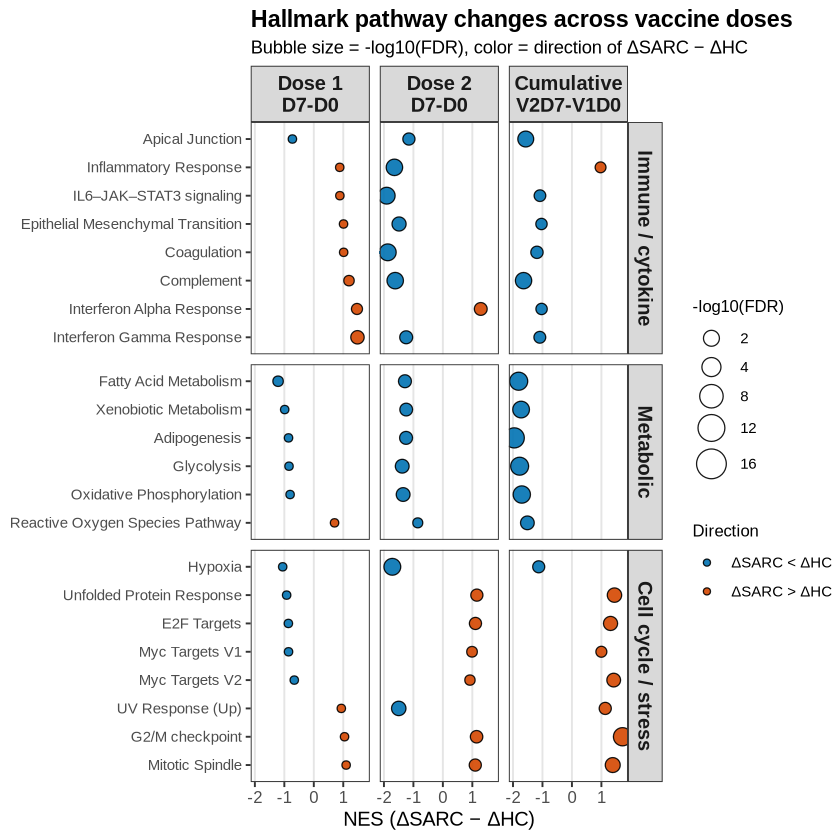

In [ ]:
## ============================================================
## Hallmark bubble plot: ΔSX − ΔHC across vaccine contrasts
## NES as x, pathways on y, bubble size = -log10(FDR),
## bubble color = direction; facets like example bubble plot.
## ============================================================

suppressPackageStartupMessages({
  library(ggplot2)
  library(dplyr)
  library(readr)
  library(stringr)
  library(forcats)
  library(purrr)
  library(tibble)
})


FIG_DIR <- here::here("figures", "main")
dir.create(FIG_DIR, recursive = TRUE, showWarnings = FALSE)

# Contrast specs + file paths
contrast_specs <- tibble::tribble(
  ~contrast_id, ~contrast_label,         ~file_H,
  "dose1",      "Dose 1 D7-D0",          file.path(TAB_DIR, "Dose1_GSEA_Hallmark_dream.csv"),
  "dose2",      "Dose 2 D7-D0",          file.path(TAB_DIR, "Dose2_GSEA_Hallmark_dream.csv"),
  "cum",        "Cumulative V2D7-V1D0",  file.path(TAB_DIR, "Dose12_GSEA_Hallmark_dream.csv")
)


load_hallmark_csv <- function(path, label) {
  if (!file.exists(path)) return(NULL)
  readr::read_csv(path, show_col_types = FALSE) %>%
    transmute(
      pathway_raw = path_clean,  # from your FGSEA output
      NES,
      padj,
      contrast = label
    )
}

df_all <- purrr::map2_dfr(
  contrast_specs$file_H,
  contrast_specs$contrast_label,
  load_hallmark_csv
)

if (nrow(df_all) == 0) {
  stop(
    "No Hallmark FGSEA CSVs found.\n",
    "Either the files do not exist at TAB_DIR or TAB_DIR/here() is wrong.\n",
    "See the 'Expecting Hallmark files' lines printed above.",
    call. = FALSE
  )
}

df_all$contrast <- factor(df_all$contrast, levels = contrast_specs$contrast_label)

## ------------------------------------------------------------
## 2. Canonical mapping + curated list + categories
## ------------------------------------------------------------

canon_map <- c(
  "interferon alpha response"        = "Interferon Alpha Response",
  "interferon gamma response"        = "Interferon Gamma Response",
  "inflammatory response"            = "Inflammatory Response",
  "tnfa signaling via nfkb"          = "TNF-α signaling via NF-κB",
  "il6 jak stat3 signaling"          = "IL6–JAK–STAT3 signaling",
  "complement"                       = "Complement",
  "coagulation"                      = "Coagulation",
  "apical junction"                  = "Apical Junction",
  "epithelial mesenchymal transition"= "Epithelial Mesenchymal Transition",
  "glycolysis"                       = "Glycolysis",
  "oxidative phosphorylation"        = "Oxidative Phosphorylation",
  "fatty acid metabolism"            = "Fatty Acid Metabolism",
  "adipogenesis"                     = "Adipogenesis",
  "xenobiotic metabolism"            = "Xenobiotic Metabolism",
  "reactive oxygen species pathway"  = "Reactive Oxygen Species Pathway",
  "unfolded protein response"        = "Unfolded Protein Response",
  "uv response up"                   = "UV Response (Up)",
  "hypoxia"                          = "Hypoxia",
  "g2m checkpoint"                   = "G2/M checkpoint",
  "mitotic spindle"                  = "Mitotic Spindle",
  "e2f targets"                      = "E2F Targets",
  "myc targets v1"                   = "Myc Targets V1",
  "myc targets v2"                   = "Myc Targets V2"
)

pathways_curated <- unname(canon_map)

category_map <- c(
  "Interferon Alpha Response"        = "Immune / cytokine",
  "Interferon Gamma Response"        = "Immune / cytokine",
  "Inflammatory Response"            = "Immune / cytokine",
  "TNF-α signaling via NF-κB"        = "Immune / cytokine",
  "IL6–JAK–STAT3 signaling"          = "Immune / cytokine",
  "Complement"                       = "Immune / cytokine",
  "Coagulation"                      = "Immune / cytokine",
  "Apical Junction"                  = "Immune / cytokine",
  "Epithelial Mesenchymal Transition"= "Immune / cytokine",
  "Glycolysis"                       = "Metabolic",
  "Oxidative Phosphorylation"        = "Metabolic",
  "Fatty Acid Metabolism"            = "Metabolic",
  "Adipogenesis"                     = "Metabolic",
  "Xenobiotic Metabolism"            = "Metabolic",
  "Reactive Oxygen Species Pathway"  = "Metabolic",
  "Unfolded Protein Response"        = "Cell cycle / stress",
  "UV Response (Up)"                 = "Cell cycle / stress",
  "Hypoxia"                          = "Cell cycle / stress",
  "G2/M checkpoint"                  = "Cell cycle / stress",
  "Mitotic Spindle"                  = "Cell cycle / stress",
  "E2F Targets"                      = "Cell cycle / stress",
  "Myc Targets V1"                   = "Cell cycle / stress",
  "Myc Targets V2"                   = "Cell cycle / stress"
)

df_clean <- df_all %>%
  mutate(
    key = pathway_raw |>
      str_to_lower() |>
      str_replace_all("[^a-z0-9 ]", "") |>
      str_squish(),
    pathway = recode(key, !!!canon_map, .default = pathway_raw)
  ) %>%
  filter(pathway %in% pathways_curated) %>%
  mutate(
    category = recode(pathway, !!!category_map, .default = "Other"),
    direction = if_else(NES >= 0, "ΔSARC > ΔHC", "ΔSARC < ΔHC"),
    neglog10FDR = -log10(padj),
    neglog10FDR = if_else(is.infinite(neglog10FDR), NA_real_, neglog10FDR)
  ) %>%
  filter(!is.na(neglog10FDR))

df_clean$neglog10FDR_capped <- pmin(df_clean$neglog10FDR, 16)

df_clean$category <- factor(
  df_clean$category,
  levels = c("Immune / cytokine", "Metabolic", "Cell cycle / stress")
)

## ------------------------------------------------------------
## 3. Alphabetical **top-to-bottom** ordering of pathways
## ------------------------------------------------------------
# df_bubble <- df_clean %>%
#   group_by(category) %>%
#   arrange(category, pathway) %>%
#   mutate(
#     pathway = fct_rev(fct_inorder(pathway))  # reverse so alphabetical is top→bottom
#   ) %>%
#   ungroup()

# ---- Order pathways within each category by Dose 1 NES (ascending) ----
dose1_label <- "Dose 1 D7-D0"  # must match contrast_specs$contrast_label exactly

order_tbl <- df_clean %>%
  filter(contrast == dose1_label) %>%
  group_by(category, pathway) %>%
  summarise(order_key = mean(NES, na.rm = TRUE), .groups = "drop")  # mean is safe if duplicates exist

# Sanity check: did we actually find Dose 1 rows?
if (nrow(order_tbl) == 0) {
  stop("No rows found for contrast == '", dose1_label, "'. Check contrast labels.", call. = FALSE)
}

# Join the Dose 1 ordering key onto all contrasts
df_bubble <- df_clean %>%
  left_join(order_tbl, by = c("category", "pathway"))

# If any pathways are missing a Dose 1 NES (shouldn't happen if curated list is present),
# push them to the bottom within each category.
df_bubble <- df_bubble %>%
  mutate(order_key = if_else(is.na(order_key), Inf, order_key)) %>%
  group_by(category) %>%
  mutate(pathway = forcats::fct_reorder(pathway, order_key, .desc = TRUE)) %>%
  ungroup()



## ------------------------------------------------------------
## 4. Bubble plot
## ------------------------------------------------------------
p_bubble <- ggplot(
  df_bubble,
  aes(x = NES, y = pathway)
) +
  geom_point(
    aes(size = neglog10FDR_capped, fill = direction),
    shape = 21, colour = "black", alpha = 0.9
  ) +
  facet_grid(
    rows = vars(category),
    cols = vars(contrast),
    scales = "free_y",
    space = "free_y",
    labeller = labeller(
    contrast = label_wrap_gen(width = 12)
    )
  ) +
  scale_fill_manual(
    name = "Direction",
    values = c("ΔSARC > ΔHC" = "#d54700ff", "ΔSARC < ΔHC" = "#0072B2")
  ) +
  scale_size_continuous(
    name = "-log10(FDR)",
    range = c(2, 8),
    breaks = c(2, 4, 8, 12, 16),
    limits = c(0, 16)
  ) +
  labs(
    x = "NES (ΔSARC − ΔHC)",
    y = NULL,
    title = "Hallmark pathway changes across vaccine doses",
    subtitle = "Bubble size = -log10(FDR), color = direction of ΔSARC − ΔHC"
  ) +
  theme_bw(base_size = 12) +
  theme(
    panel.grid.major.x = element_line(colour = "grey90"),
    panel.grid.major.y = element_blank(),
    panel.grid.minor   = element_blank(),
    strip.text.x       = element_text(face = "bold", size = 12),
    strip.text.y       = element_text(face = "bold", size = 12),
    axis.text.y        = element_text(size = 9), 
    axis.text.x        = element_text(size = 10),
    legend.position    = "right",
    legend.title       = element_text(size = 10),
    legend.text        = element_text(size = 9),
    plot.title         = element_text(size = 14, face = "bold",
                                      margin = margin(b = 5)),
    plot.subtitle      = element_text(size = 11, margin = margin(b = 5))
  )

## ------------------------------------------------------------
## 5. Save PNG and PDF
## ------------------------------------------------------------
png_file <- file.path(FIG_DIR,"Fig5_Hallmark_bubble_all_contrasts_alpha_top_to_bottom.png")
pdf_file <- file.path(FIG_DIR,"Fig5_Hallmark_bubble_all_contrasts_alpha_top_to_bottom.pdf")

ggsave(png_file, p_bubble, width = 10, height = 8, dpi = 600)
ggsave(pdf_file, p_bubble, width = 10, height = 8, useDingbats = FALSE)

p_bubble